# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Utility-Functions" data-toc-modified-id="Utility-Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Utility Functions</a></div><div class="lev1 toc-item"><a href="#Building-a-Convolutional-Neural-Network" data-toc-modified-id="Building-a-Convolutional-Neural-Network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Building a Convolutional Neural Network</a></div><div class="lev2 toc-item"><a href="#Model-Definition" data-toc-modified-id="Model-Definition-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Model Definition</a></div><div class="lev2 toc-item"><a href="#Data-Generator" data-toc-modified-id="Data-Generator-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Data Generator</a></div><div class="lev2 toc-item"><a href="#Training" data-toc-modified-id="Training-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Training</a></div><div class="lev2 toc-item"><a href="#Data-Augmentation" data-toc-modified-id="Data-Augmentation-24"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Data Augmentation</a></div><div class="lev1 toc-item"><a href="#Visualizing-Feature-Maps" data-toc-modified-id="Visualizing-Feature-Maps-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Visualizing Feature Maps</a></div><div class="lev1 toc-item"><a href="#Dense-Layer-Visualization" data-toc-modified-id="Dense-Layer-Visualization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dense Layer Visualization</a></div><div class="lev1 toc-item"><a href="#Visualizing-Convnet-Filters" data-toc-modified-id="Visualizing-Convnet-Filters-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualizing Convnet Filters</a></div>

In [2]:
%%capture
!pip install tensorflow
!pip install keras-vis
!pip install tensorflow keras-vis
!pip install kaggle

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os
import pickle
import zipfile
import shutil
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras import activations
from tensorflow.keras import layers
#from vis.utils import utils
#from vis.visualization import visualize_activation, get_num_filters
#from vis.input_modifiers import Jitter


# Utility Functions

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['accuracy'])
    accuracy = smooth_curve(history.history['accuracy'][:steps])
    val_accuracy = smooth_curve(history.history['val_accuracy'][:steps])
    loss = smooth_curve(history.history['loss'][:steps])
    val_loss = smooth_curve(history.history['val_loss'][:steps])

    plt.figure(figsize=(6, 4))
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()

    plt.figure(figsize=(6, 4))
    plt.plot(accuracy, c='#0c7cba', label='Train Acc')
    plt.plot(val_accuracy, c='#0f9d58', label='Val Acc')
    plt.xticks(range(0, len(accuracy), 5))
    plt.xlim(0, len(accuracy))
    plt.title('Train Accuracy: %.3f, Val Accuracy: %.3f' % (accuracy[-1], val_accuracy[-1]), fontsize=12)
    plt.legend()

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

def load_history(fn):
    class Temp():
        pass
    history = Temp()
    with open(fn, 'rb') as fr:
        history.history = pickle.load(fr)
    return history

def jitter(img, amount=32):
    ox, oy = np.random.randint(-amount, amount+1, 2)
    return np.roll(np.roll(img, ox, -1), oy, -2), ox, oy

def reverse_jitter(img, ox, oy):
    return np.roll(np.roll(img, -ox, -1), -oy, -2)

def plot_image(img):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

# Building a Convolutional Neural Network

## Model Definition

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1',
                 input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2), name='maxpool_1'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model.add(MaxPooling2D((2, 2), name='maxpool_2'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model.add(MaxPooling2D((2, 2), name='maxpool_3'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model.add(MaxPooling2D((2, 2), name='maxpool_4'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', name='dense_1'))
model.add(Dense(256, activation='relu', name='dense_2'))
model.add(Dense(1, activation='sigmoid', name='output'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Data Generator

In [ ]:
!kaggle datasets download -d jhe2918/cats-and-dogs-small

Dataset URL: https://www.kaggle.com/datasets/jhe2918/cats-and-dogs-small

License(s): unknown


 98% 85.0M/86.7M [00:05<00:00, 23.2MB/s]

100% 86.7M/86.7M [00:05<00:00, 16.2MB/s]


In [ ]:
base_dir = '/content/cats-and-dogs-small.zip'
zip_ref = zipfile.ZipFile(base_dir, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
# Directorio base de extracción
extract_dir = '/content/cats_and_dogs_small'

# Rutas para las imágenes de gatos y perros
source_cats_dir = os.path.join(extract_dir, 'test', 'cats')
source_dogs_dir = os.path.join(extract_dir, 'test', 'dogs')

# Función para crear directorios si no existen
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Función para preparar los datos y dividirlos en conjuntos de entrenamiento, validación y prueba
def prepare_data(source_dir, base_dir, category):
    if not os.path.exists(source_dir):
        print(f"Directorio {source_dir} no encontrado. Verifica la estructura.")
        return
    images = os.listdir(source_dir)
    train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
    validation_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    # Directorios de destino
    train_dir = os.path.join(base_dir, 'train', category)
    validation_dir = os.path.join(base_dir, 'validation', category)
    test_dir = os.path.join(base_dir, 'test', category)

    # Crear directorios de destino
    create_dir(train_dir)
    create_dir(validation_dir)
    create_dir(test_dir)

    # Copiar imágenes a los directorios correspondientes
    for image in train_images:
        src_path = os.path.join(source_dir, image)
        dst_path = os.path.join(train_dir, image)
        if src_path != dst_path:  # Verificar que no es la misma ruta
            shutil.copy(src_path, dst_path)

    for image in validation_images:
        src_path = os.path.join(source_dir, image)
        dst_path = os.path.join(validation_dir, image)
        if src_path != dst_path:  # Verificar que no es la misma ruta
            shutil.copy(src_path, dst_path)

    for image in test_images:
        src_path = os.path.join(source_dir, image)
        dst_path = os.path.join(test_dir, image)
        if src_path != dst_path:  # Verificar que no es la misma ruta
            shutil.copy(src_path, dst_path)

# Preparar datos para gatos y perros
prepare_data(source_cats_dir, extract_dir, 'cats')
prepare_data(source_dogs_dir, extract_dir, 'dogs')

print("Imágenes divididas y copiadas a carpetas correspondientes.")

# Configuración de ImageDataGenerator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Crear generadores de datos
train_generator = train_datagen.flow_from_directory(
    os.path.join(extract_dir, 'train'),
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    os.path.join(extract_dir, 'validation'),
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(extract_dir, 'test'),
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

print("Generadores creados y listos para ser utilizados.")

Imágenes divididas y copiadas a carpetas correspondientes.

Found 2700 images belonging to 2 classes.

Found 1150 images belonging to 2 classes.

Found 1000 images belonging to 2 classes.

Generadores creados y listos para ser utilizados.


## Training

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2
)


Epoch 1/20

100/100 - 16s - 164ms/step - accuracy: 0.5030 - loss: 0.6948 - val_accuracy: 0.4890 - val_loss: 0.6934

Epoch 2/20

100/100 - 2s - 22ms/step - accuracy: 0.5071 - loss: 0.6931 - val_accuracy: 0.6067 - val_loss: 0.6896

Epoch 3/20

100/100 - 6s - 57ms/step - accuracy: 0.4975 - loss: 0.6935 - val_accuracy: 0.4990 - val_loss: 0.6928

Epoch 4/20

100/100 - 1s - 13ms/step - accuracy: 0.5029 - loss: 0.6937 - val_accuracy: 0.5067 - val_loss: 0.6881

Epoch 5/20

100/100 - 5s - 46ms/step - accuracy: 0.5185 - loss: 0.6926 - val_accuracy: 0.5840 - val_loss: 0.6858

Epoch 6/20

100/100 - 1s - 12ms/step - accuracy: 0.5986 - loss: 0.6869 - val_accuracy: 0.6133 - val_loss: 0.6696

Epoch 7/20

100/100 - 9s - 93ms/step - accuracy: 0.5600 - loss: 0.6823 - val_accuracy: 0.5110 - val_loss: 0.6899

Epoch 8/20

100/100 - 1s - 11ms/step - accuracy: 0.5329 - loss: 0.6888 - val_accuracy: 0.5133 - val_loss: 0.6902

Epoch 9/20

100/100 - 10s - 100ms/step - accuracy: 0.5610 - loss: 0.6840 - val_accurac

In [ ]:
model.save('model.h5')
save_history(history, 'history.bin')

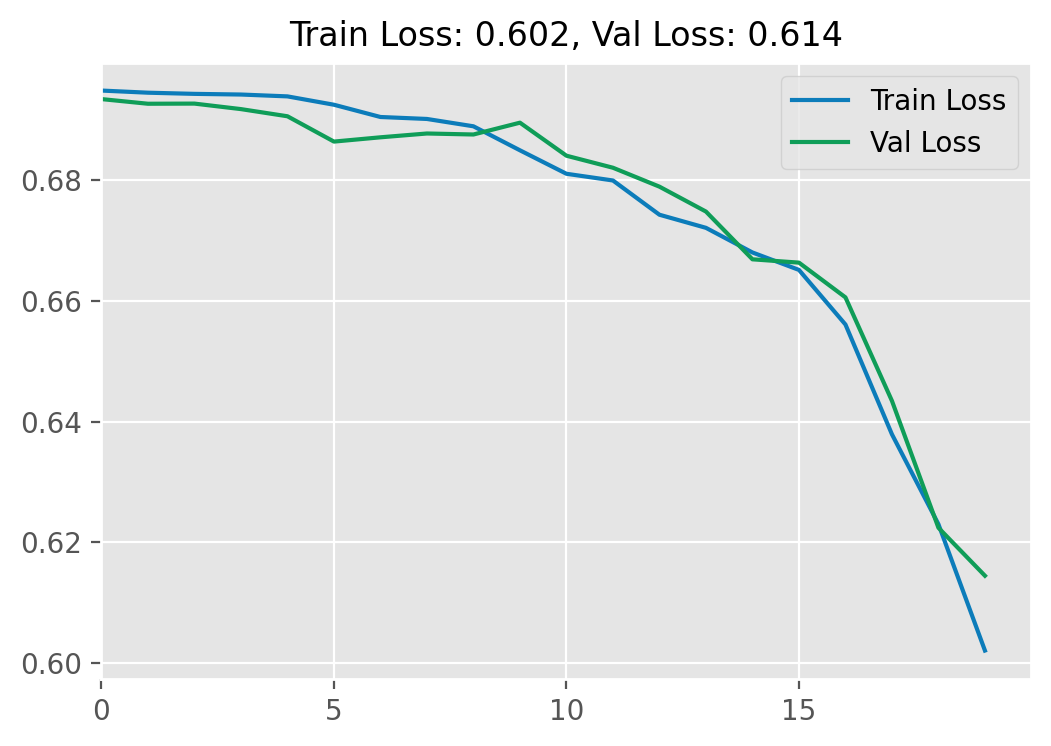

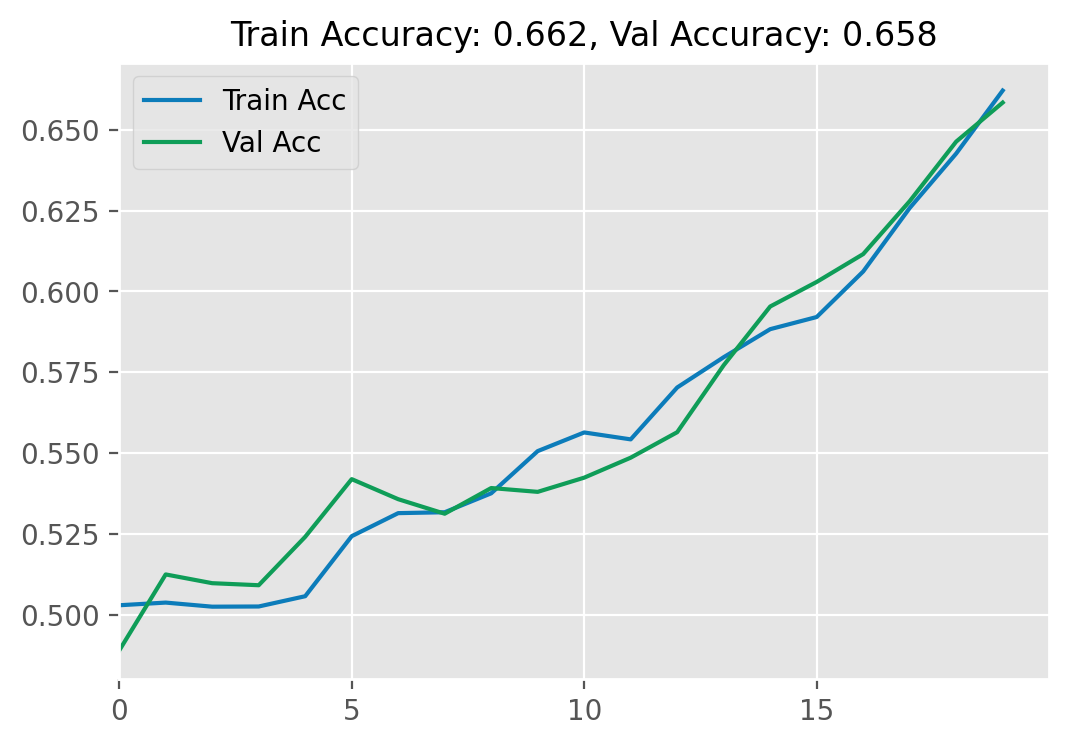

In [ ]:
history = load_history('history.bin')
plot_compare(history)

## Data Augmentation

In [ ]:
model_aug = Sequential()
model_aug.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1',
                 input_shape=(150, 150, 3)))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_1'))
model_aug.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_2'))
model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_3'))
model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_4'))
model_aug.add(Flatten())
model_aug.add(Dropout(0.5))
model_aug.add(Dense(512, activation='relu', name='dense_1'))
model_aug.add(Dense(256, activation='relu', name='dense_2'))
model_aug.add(Dense(1, activation='sigmoid', name='output'))

In [ ]:
model_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = os.path.join(extract_dir, '/content/cats_and_dogs_small/train')
validation_dir = os.path.join(extract_dir, '/content/cats_and_dogs_small/validation')

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

# early_stop = EarlyStopping(monitor='val_loss', patience=6, verbose=1)
history_aug = model_aug.fit(train_generator, steps_per_epoch=100, epochs=60,
                                      validation_data=validation_generator, validation_steps=50, verbose=1)

Found 2700 images belonging to 2 classes.

Found 1150 images belonging to 2 classes.

Epoch 1/60

100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 248ms/step - accuracy: 0.4836 - loss: 0.7063 - val_accuracy: 0.5000 - val_loss: 0.6931

Epoch 2/60

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 193ms/step - accuracy: 0.5186 - loss: 0.6931 - val_accuracy: 0.5809 - val_loss: 0.6911

Epoch 3/60

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - accuracy: 0.5423 - loss: 0.6926 - val_accuracy: 0.5052 - val_loss: 0.6879

Epoch 4/60

100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 194ms/step - accuracy: 0.5265 - loss: 0.6899 - val_accuracy: 0.5687 - val_loss: 0.6834

Epoch 5/60

100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 183ms/step - accuracy: 0.5316 - loss: 0.6893 - val_accuracy: 0.5835 - val_loss: 0.6781

Epoch 6/60

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 193ms/step - accuracy: 0.5603 - loss: 0.6863 - val_accuracy: 0.5730 - val_loss: 0.6785

Epoch 7/60

100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 197ms/step - accuracy: 0.5697 - loss: 0.6821 - val_accuracy: 0.5835 - v

In [ ]:
model_aug.save('model_aug.h5')
save_history(history_aug, 'history_aug.bin')

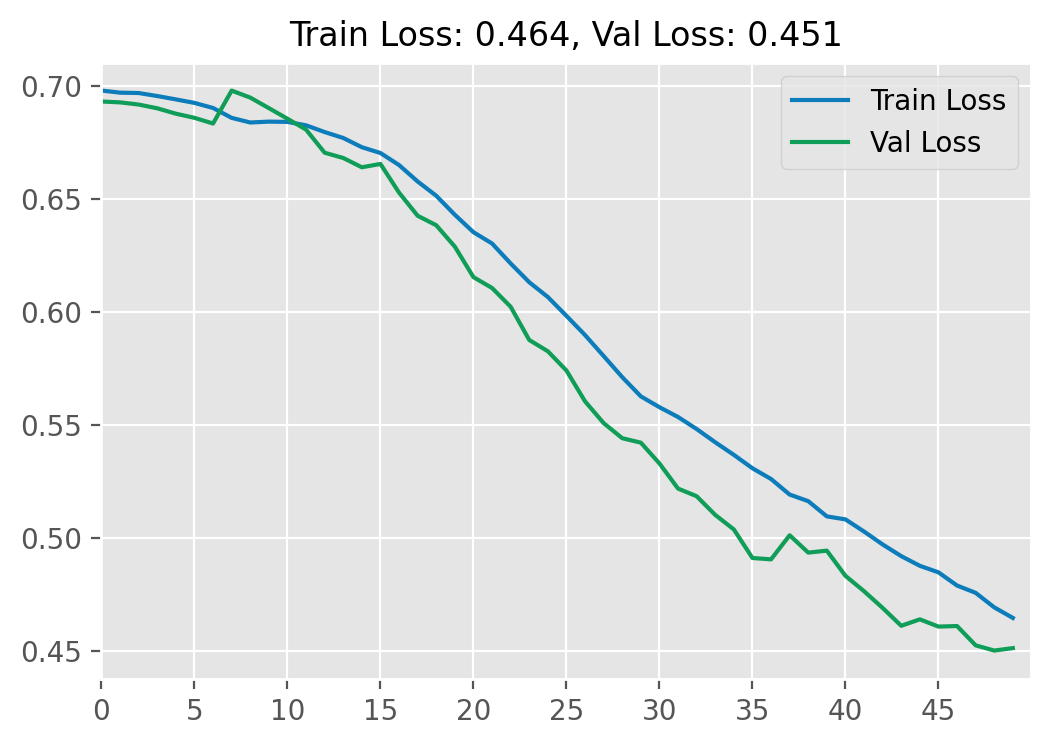

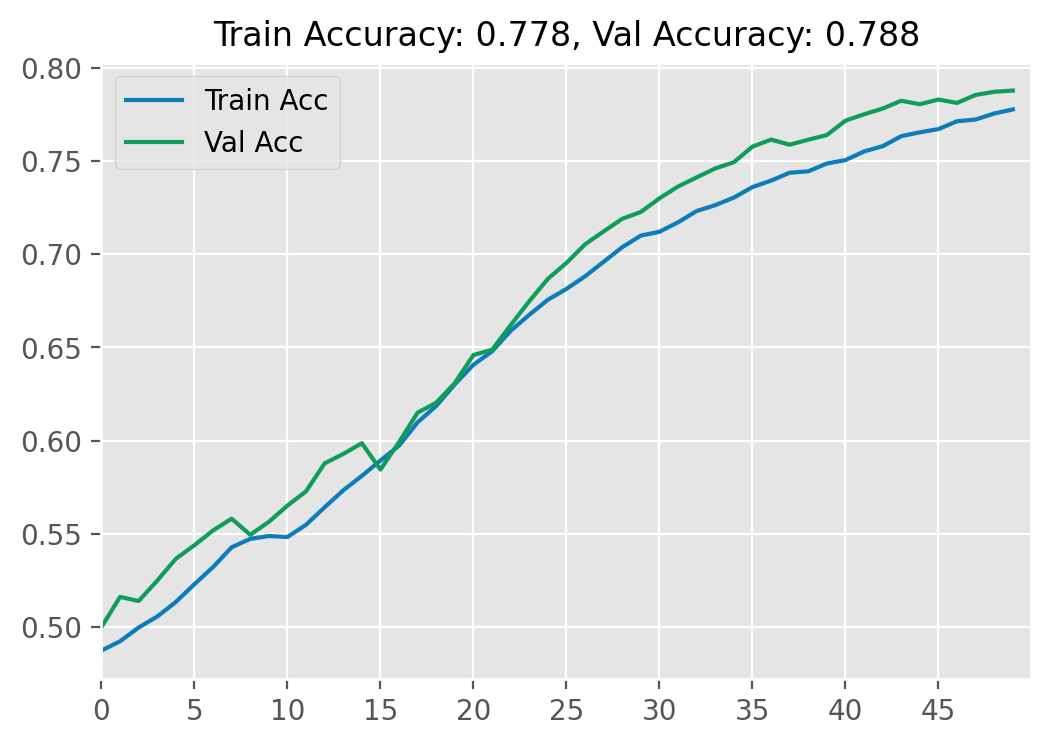

In [ ]:
history_aug = load_history('history_aug.bin')
plot_compare(history_aug, steps=50)

# Visualizing Feature Maps

In [ ]:
img_path = '/content/cats_and_dogs_small/train/cats/cat.54.jpg'

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


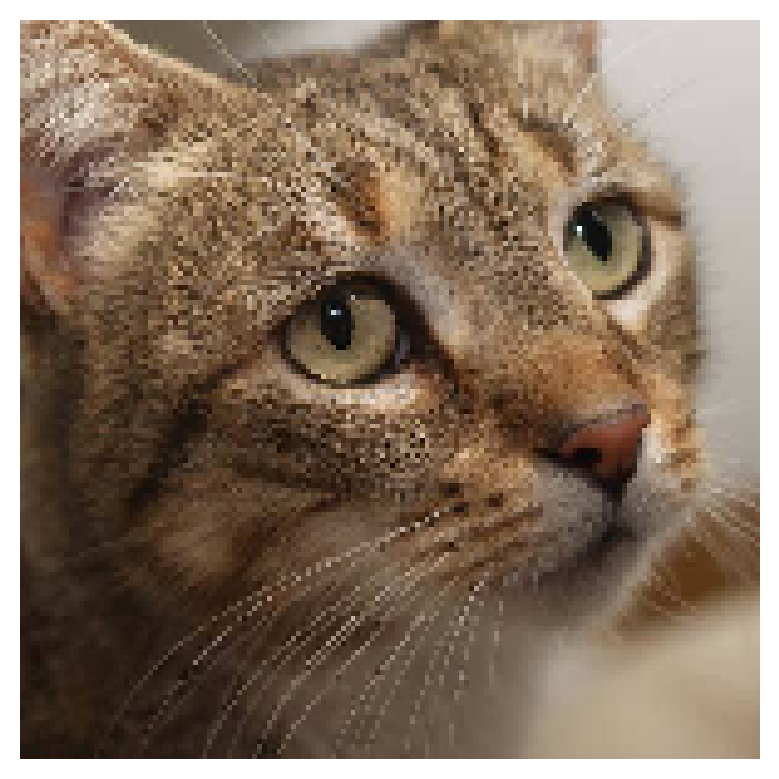

In [ ]:
plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

In [ ]:
vgg = VGG16(weights='imagenet', include_top=False)
vgg.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


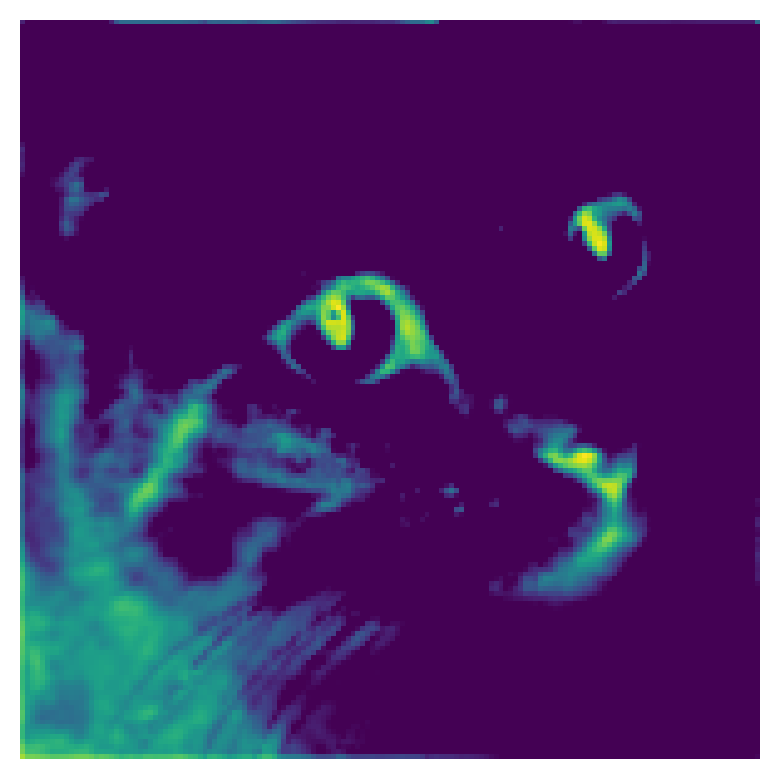

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in vgg.layers if 'conv1' in layer.name]
activation_model = Model(inputs=vgg.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_tensor)

first_layer_activation = intermediate_activations[0]

plt.imshow(first_layer_activation[0, :, :, 19], cmap='viridis')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


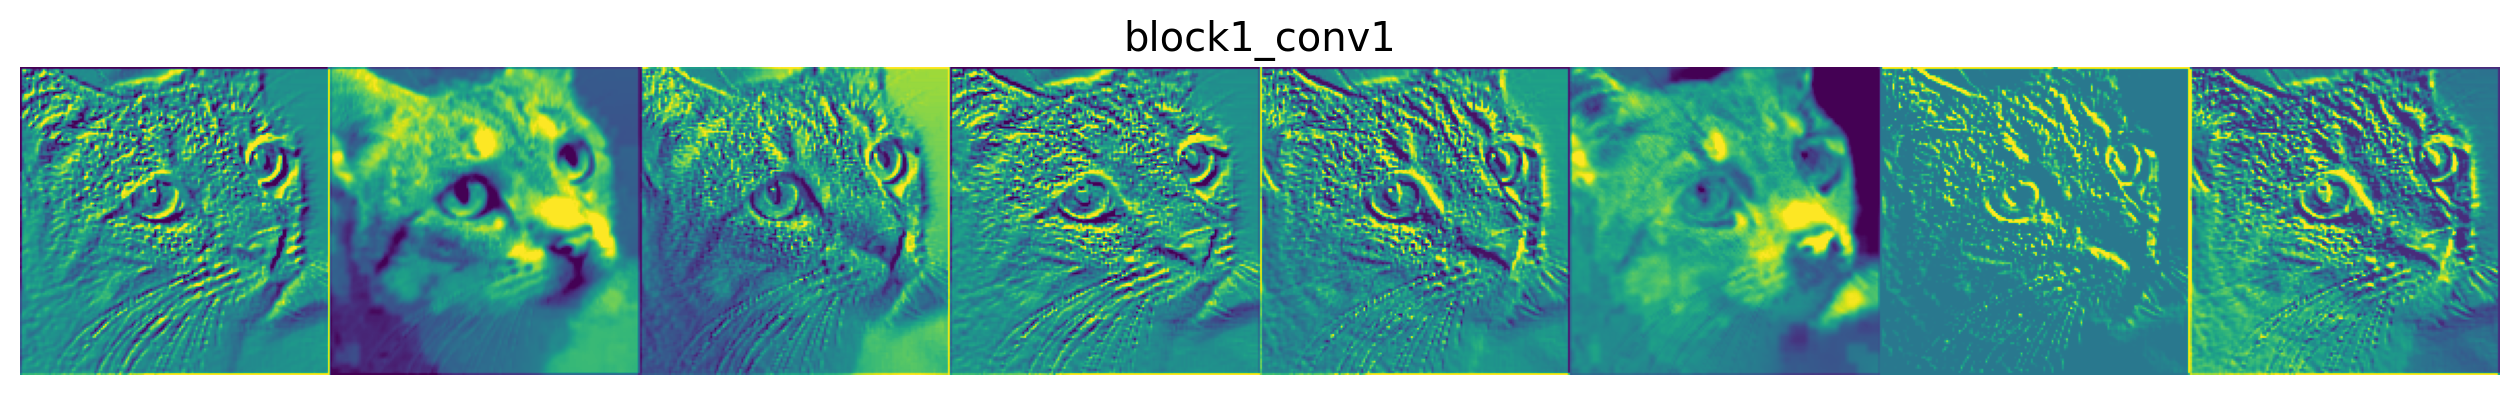

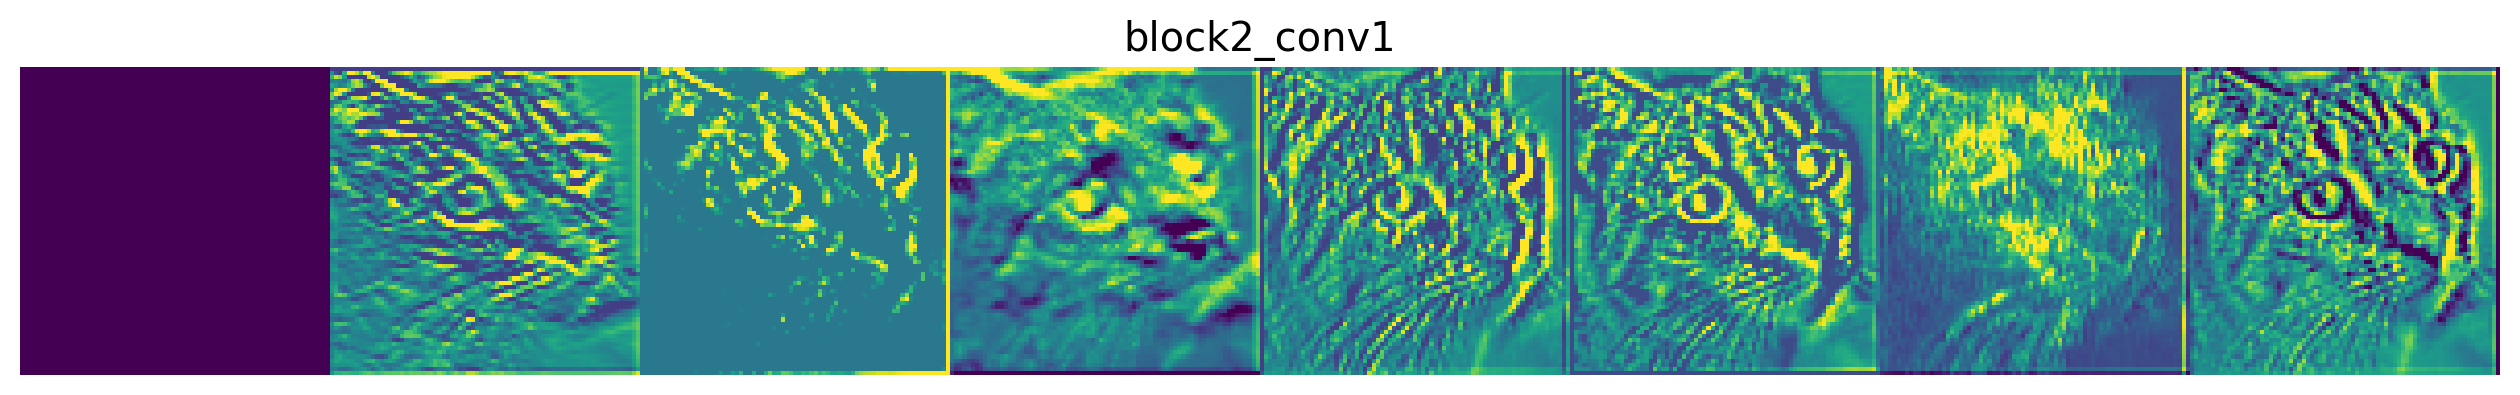

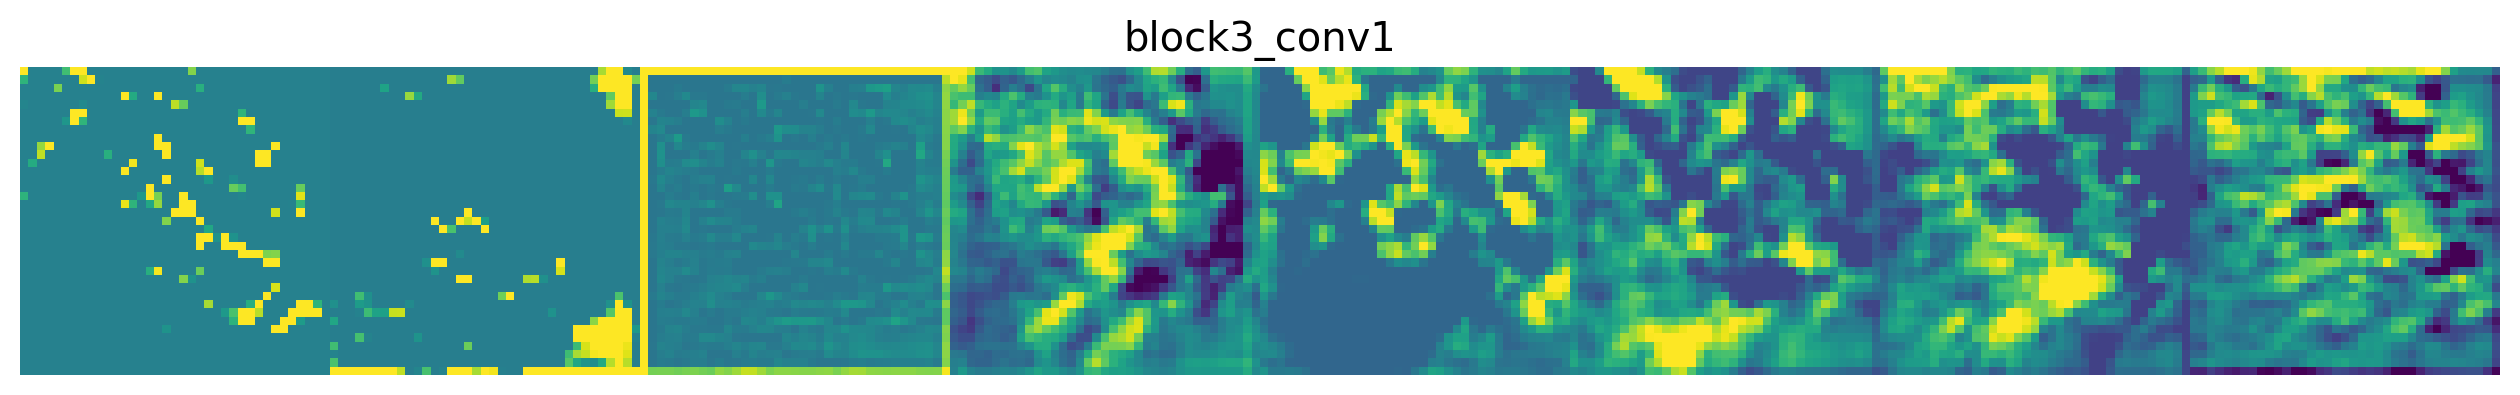

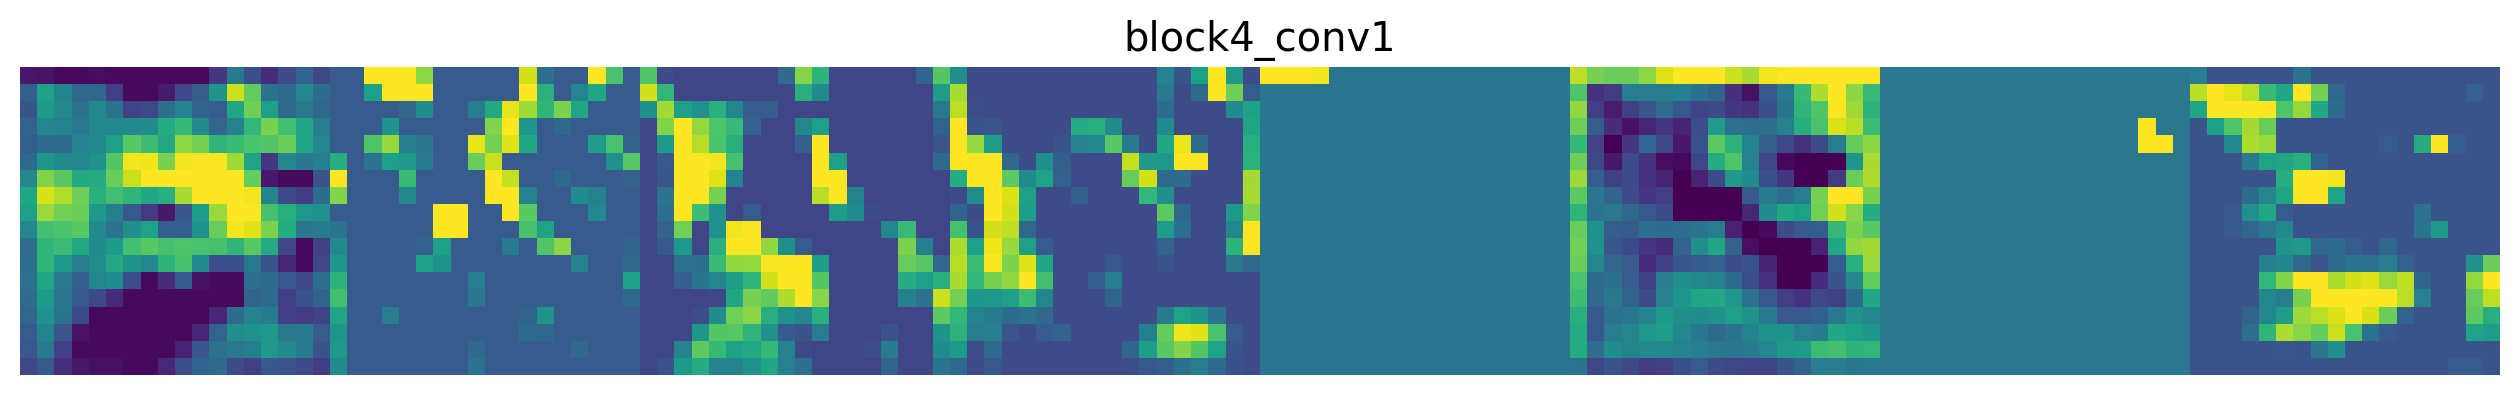

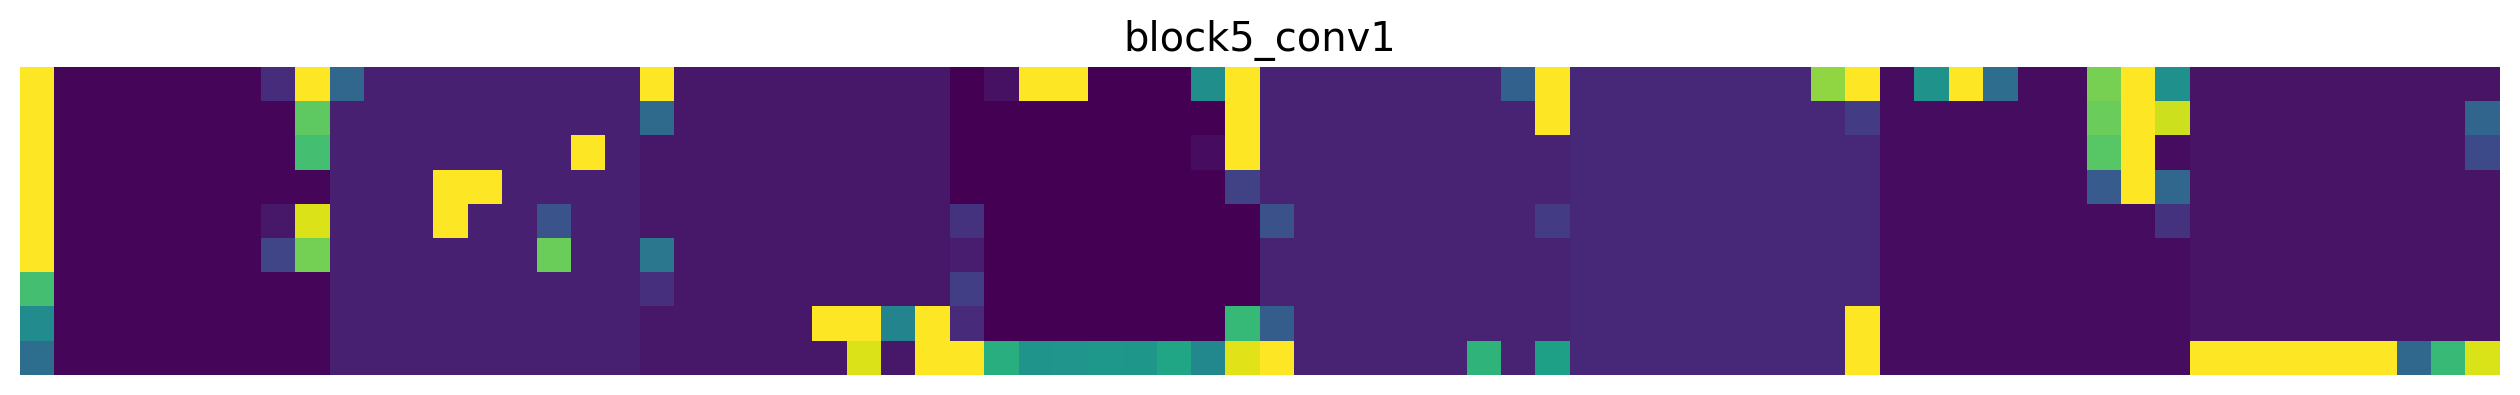

In [ ]:
layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

layer_outputs = [layer.output for layer in vgg.layers if layer.name in layer_names]
activation_model = Model(inputs=vgg.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_tensor)

images_per_row = 8
max_images = 8
# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, intermediate_activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]
    n_features = min(n_features, max_images)

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 2. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.axis('off')
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

# Dense Layer Visualization

In [3]:
model = VGG16(weights='imagenet', include_top=True)



553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
layer_names = [layer.name for layer in model.layers]
print(layer_names)  # Imprime los nombres de las capas para confirmación
layer_idx = layer_names.index('predictions')


['input_layer', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool', 'flatten', 'fc1', 'fc2', 'predictions']


In [5]:
%%capture
pip install tf-keras-vis


In [5]:
%%capture
!pip install tf-keras-vis tensorflow

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D
from tf_keras_vis.activation_maximization.regularizers import TotalVariation2D


In [9]:
# Modificar el modelo para maximizar la activación
replace2linear = ReplaceToLinear()
score = CategoricalScore([20])  # Clase 'ouzel' en ImageNet

# Configurar ActivationMaximization
activation_maximization = ActivationMaximization(model, model_modifier=replace2linear)

# Generar la imagen que maximiza la activación
img = activation_maximization(score, seed_input=None)

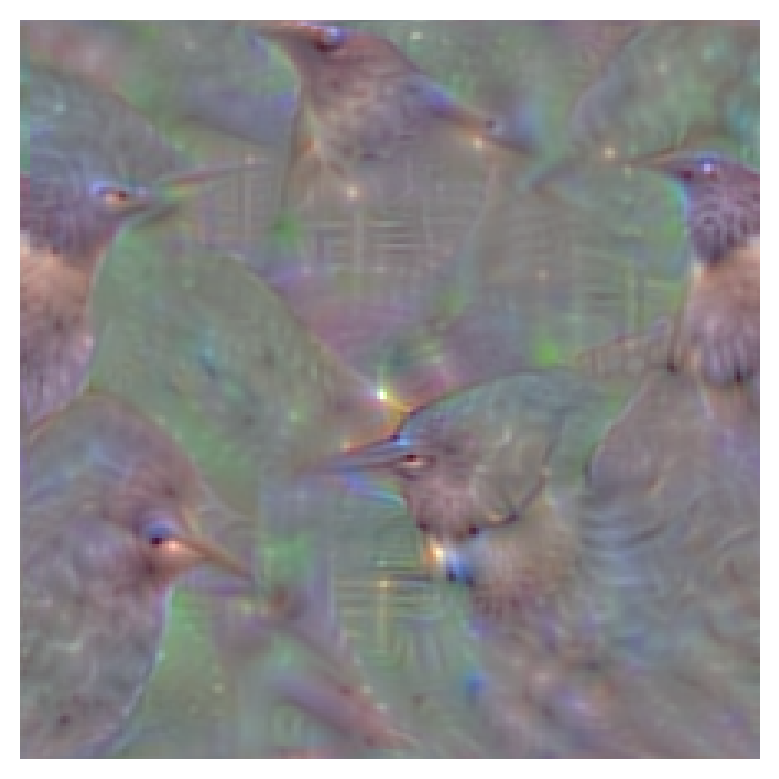

In [10]:
# Convertir la imagen a un formato adecuado para visualizar con Matplotlib
img = img[0]  # img es una lista con una sola imagen
img = np.uint8(img)  # Convertir a uint8 para asegurar que esté en el rango 0-255

# Visualizar la imagen
plt.imshow(img)
plt.axis('off')  # Opcional: oculta los ejes
plt.show()


In [14]:

import tensorflow as tf

In [32]:
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D
from tf_keras_vis.activation_maximization.regularizers import TotalVariation2D
# Modificar el modelo para maximizar la activación
replace2linear = ReplaceToLinear()
score = CategoricalScore([20])  # Clase 'ouzel' en ImageNet

# Configurar ActivationMaximization
activation_maximization = ActivationMaximization(model, model_modifier=replace2linear)

# Generar la imagen que maximiza la activación
img = activation_maximization(
    score,
    steps=1000, input_modifiers = [Jitter(16), Rotate2D(degree=0.15)],
regularizers=[TotalVariation2D(weight=5)])

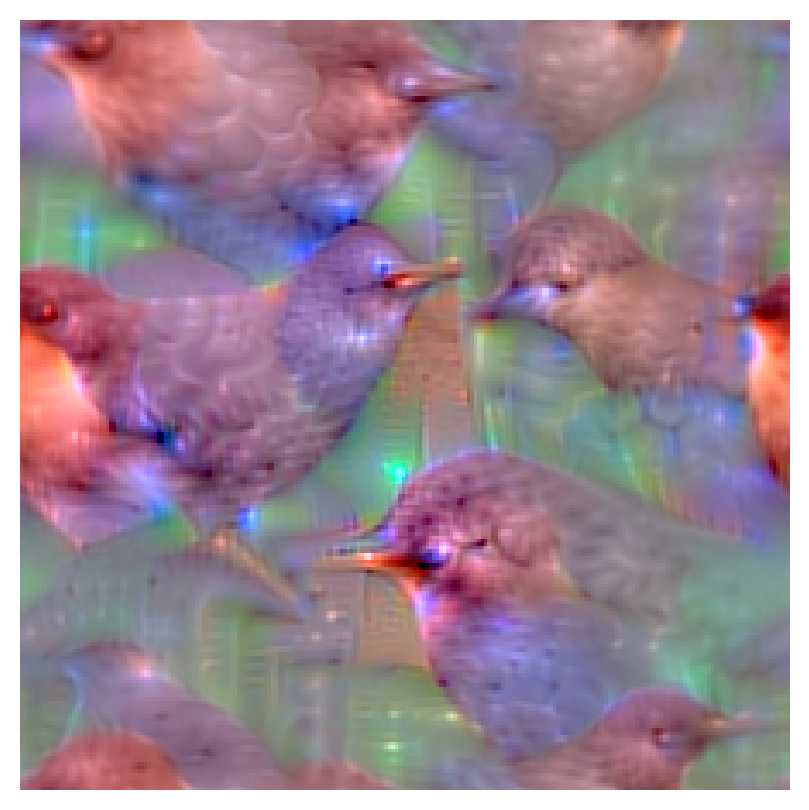

In [33]:
def plot_image(img):
    img = img.numpy()  # Convertir el tensor a un array de NumPy
    img = (img - img.min()) / (img.max() - img.min())  # Normalizar al rango [0, 1]
    plt.figure(figsize=(5, 5))
    plt.imshow(img[0])  # Asegurarse de seleccionar la primera imagen en el batch
    plt.axis('off')
    plt.show()

# Visualizar la imagen generada
plot_image(img)

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


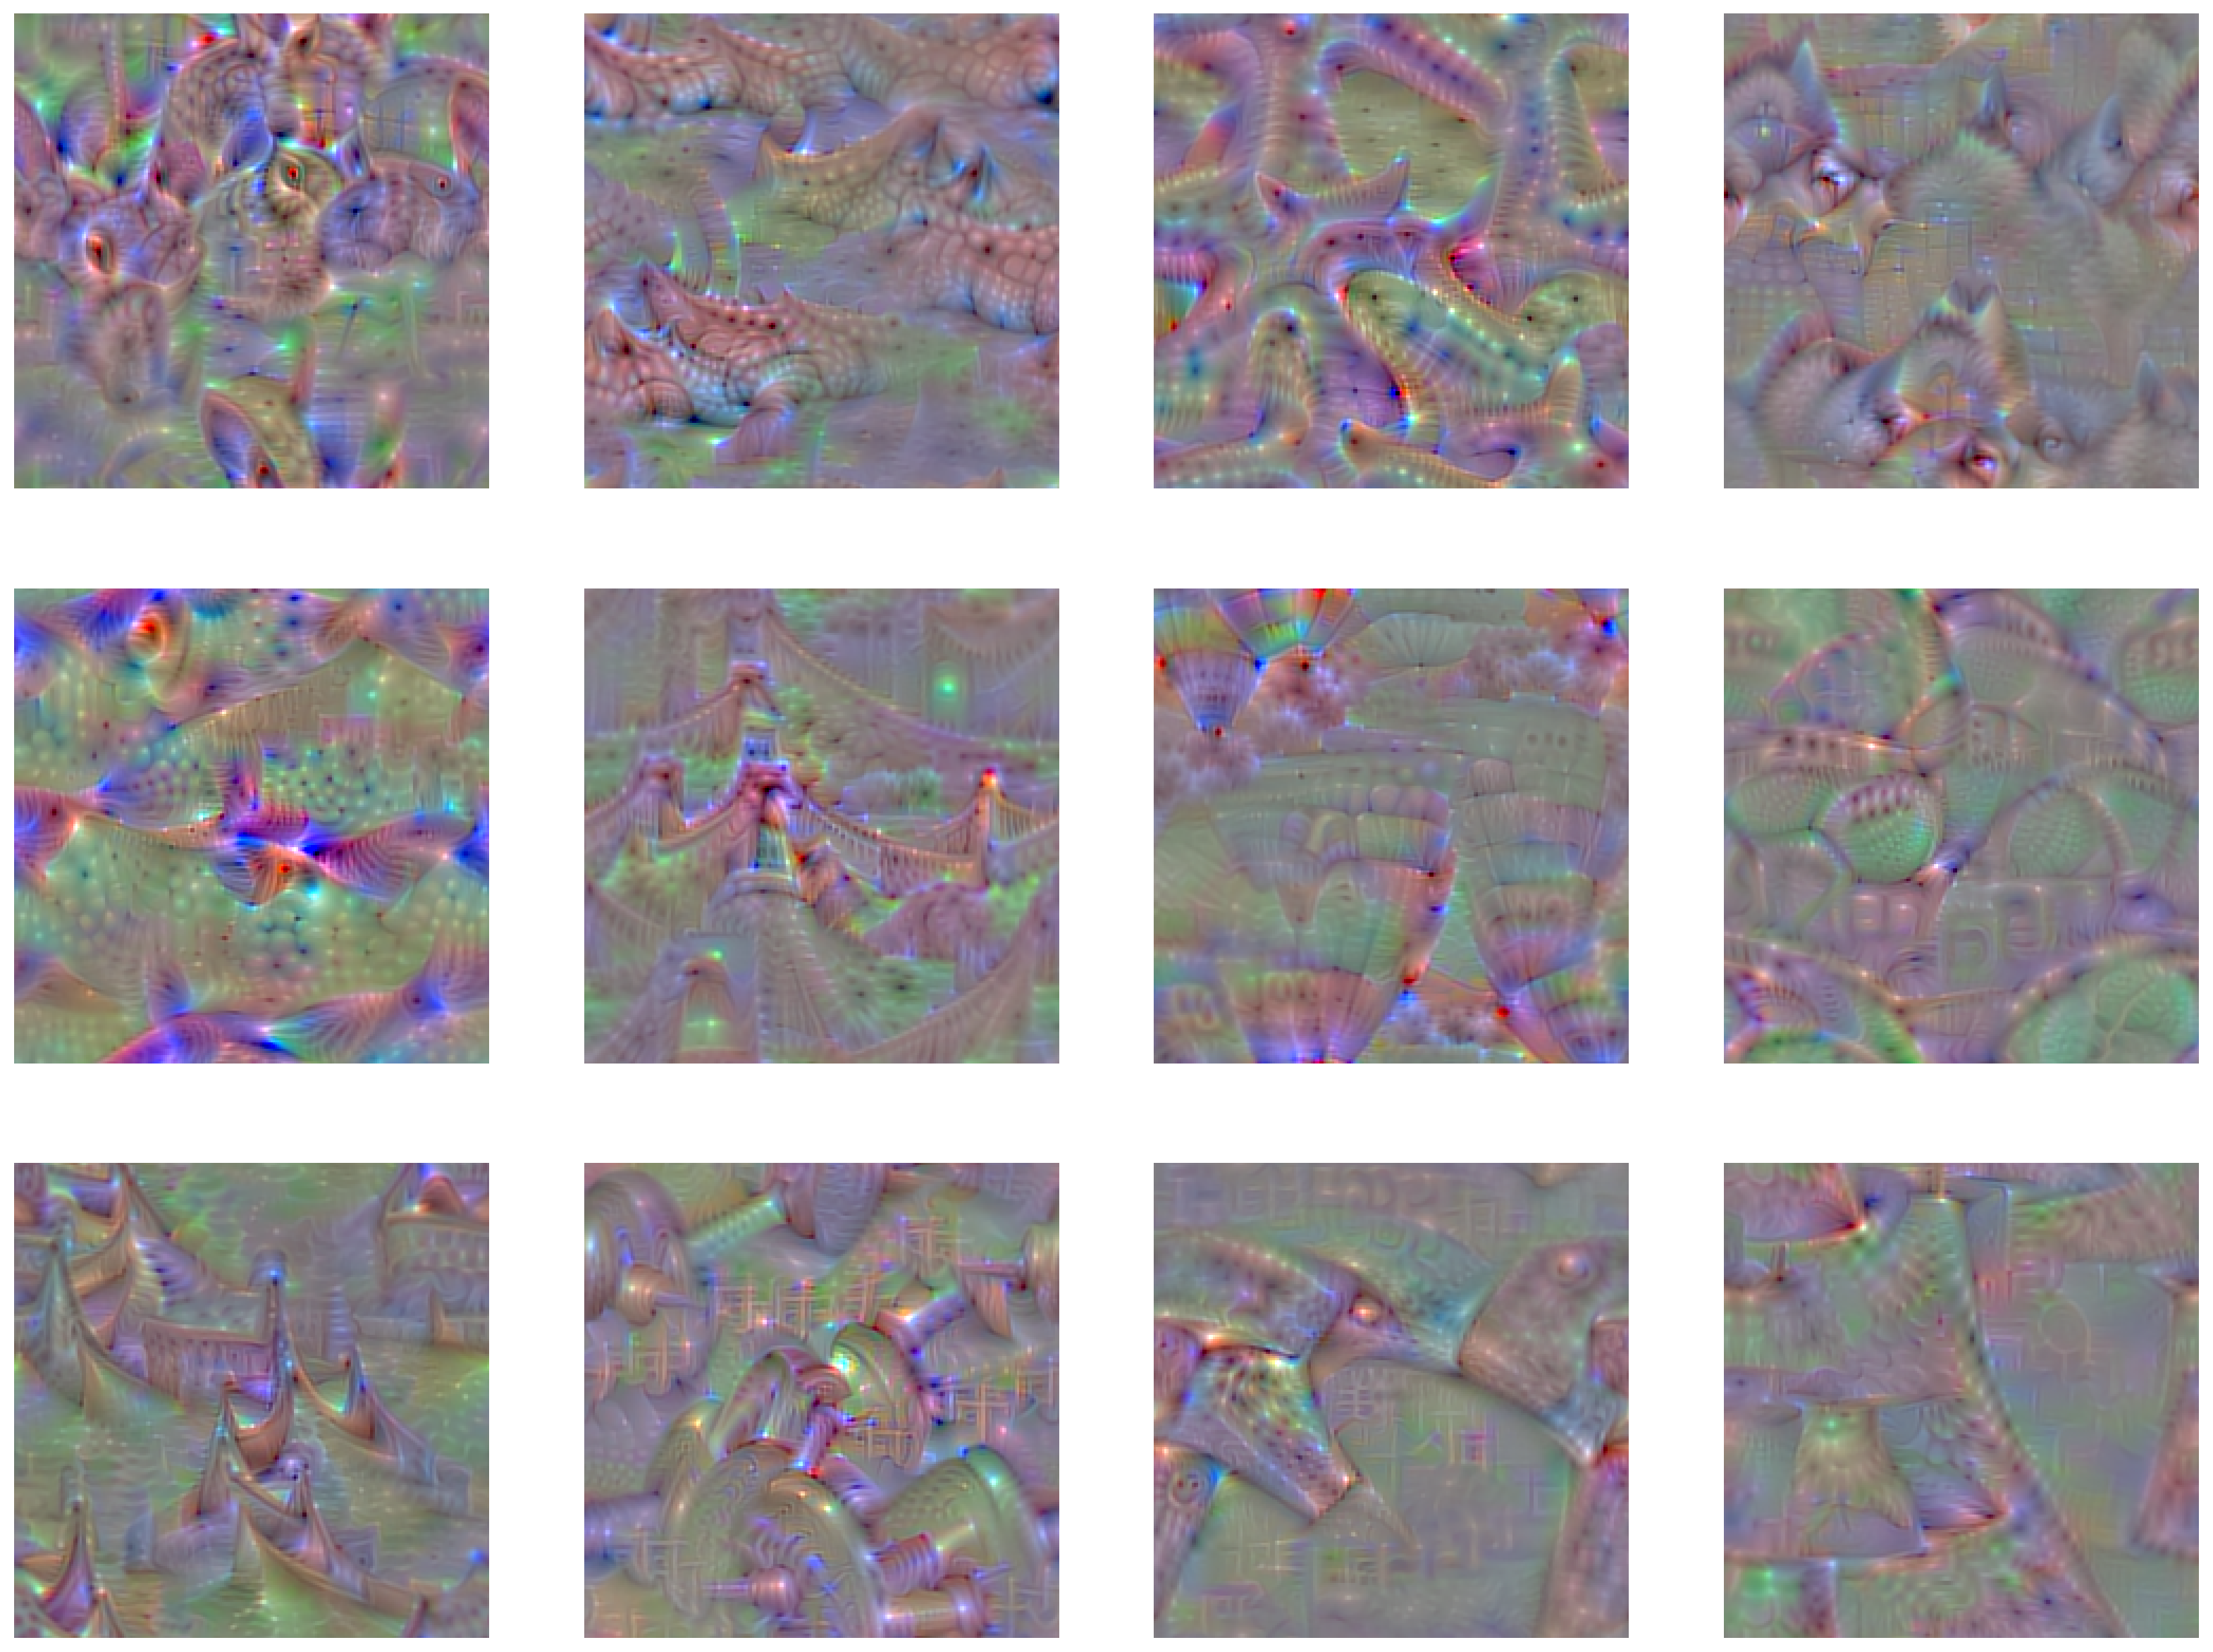

In [7]:
model = VGG16(weights='imagenet', include_top=True)
score = CategoricalScore([20]) 

# Modificar el modelo para maximizar la activación en la capa final
replace2linear = ReplaceToLinear()

# Inicializar listas
initial = []
tuples = []
image_paths = []

# Procesar cada línea de códigos
codes = '''
rabbit 330
crocodile 49
starfish 327
husky 248
goldfish 1
bridge 839
balloon 417
tennis ball 852
gondola 576
dumbbell 543
hammer 587
lamp 846
'''

for line in codes.strip().split('\n'):
    name, idx = line.rsplit(' ', 1)
    idx = int(idx)

    # Definir la clase objetivo
    score = CategoricalScore([idx])

    # Generar la imagen inicial
    activation_maximization = ActivationMaximization(model, model_modifier=replace2linear)
    img = activation_maximization(score, steps=100)

    # Convertir el tensor a un array de NumPy
    img_np = img[0].numpy()

    # Normalizar a [0, 1] si es necesario
    if img_np.dtype.kind == 'f':  # Si es flotante
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    # Guardar la imagen en disco y liberar memoria
    img_path = f'./{name}_{idx}_initial.png'
    plt.imsave(img_path, img_np, format='png')  # Guardar la imagen
    initial.append(img_path)  # Guardar la ruta de la imagen en lugar de la imagen misma
    tuples.append((name, idx))

# Visualizar y guardar imágenes con nombres
for i, (name, idx) in enumerate(tuples):
    score = CategoricalScore([idx])

    # Cargar la imagen inicial desde disco
    img_np = plt.imread(initial[i])

    # Generar la imagen usando la imagen inicial como semilla
    activation_maximization = ActivationMaximization(model, model_modifier=replace2linear)
    img = activation_maximization(score,
                                  steps=400, input_modifiers = [Jitter(16), Rotate2D(degree=0.15)],
                                  regularizers=[TotalVariation2D(weight=5)])

    # Convertir el tensor a un array de NumPy
    img_np = img[0].numpy()

    # Normalizar a [0, 1] si es necesario
    if img_np.dtype.kind == 'f':  # Si es flotante
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    # Convertir a uint8 para asegurar que esté en el rango 0-255
    img_np = np.uint8(img_np * 255)

    # Guardar la imagen final en disco y liberar memoria
    img_path = f'./{name}_{idx}_final.png'
    plt.imsave(img_path, img_np, format='png')  # Guardar la imagen
    image_paths.append(img_path)  # Guardar la ruta de la imagen en lugar de la imagen misma

# Crear una imagen de collage con 4 columnas y 3 filas
cols = 4
rows = 3
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))  # Ajustar el tamaño del collage

for i, img_path in enumerate(image_paths):
    img_np = plt.imread(img_path)  # Cargar la imagen desde disco
    ax = axes[i // cols, i % cols]
    ax.imshow(img_np)
    ax.axis('off')

for j in range(i + 1, rows * cols):
    axes[j // cols, j % cols].axis('off')

plt.show()
